# Flood risk assessment

In this notebook, we will perform a **flood damage and risk assessment** for transportation infrastructure, specifically focusing on roads. The assessment is based on combining hazard data (e.g., flood depths) with vulnerability curves to estimate the potential damage to infrastructure.

We will follow the steps outlined below to conduct the assessment:

1. **Loading the necessary packages:**  
   We will import the Python libraries required for data handling, analysis, and visualization.

2. **Loading the data:**  
   The infrastructure data (e.g., roads) and hazard data (e.g., flood depths) will be loaded into the notebook.

3. **Preparing the data:**  
   The infrastructure and hazard data will be processed and data gaps can be filled, if required.

4. **Performing the damage assessment:**  
   We will apply vulnerability curves to estimate the potential damage based on the intensity of the hazard.

5. **Visualizing the results:**  
   Finally, we will visualize the estimated damage using graphs and maps to illustrate the impact on transportation infrastructure.

## 1. Loading the Necessary Packages
To perform the assessment, we are going to make use of several [python packages](https://docs.python.org/3/tutorial/modules.html#packages).

In case you run this in Google Colab, you will have to install the packages below **(remove the hashtag in front of them)**.

In [1]:
#!pip install damagescanner==0.9b14
#!pip install contextily
#!pip install exactextract
#!pip install lonboard

In this step, we will import all the required Python libraries for data manipulation, spatial analysis, and visualization.

In [3]:
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely

import matplotlib.pyplot as plt
import contextily as cx

import damagescanner.download as download
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data
from damagescanner.base_values import DICT_CIS_VULNERABILITY_FLOOD

from lonboard import viz

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

### Specify the country of interest

Before we continue, we should specify the country for which we want to assess the damage. We use the ISO3 code for the country to download the OpenStreetMap data.

In [4]:
country_full_name = 'Angola'
country_iso3 = 'AGO'

## 2. Loading the Data
In this step, we will load four key datasets:

1. **Infrastructure data:**  
   This dataset contains information on the location and type of transportation infrastructure (e.g., roads). Each asset may have attributes such as type, length, and replacement cost.

2. **Hazard data:**  
   This dataset includes information on the hazard affecting the infrastructure (e.g., flood depth at various locations).

3. **Vulnerability curves:**  
   Vulnerability curves define how the infrastructure's damage increases with the intensity of the hazard. For example, flood depth-damage curves specify how much damage occurs for different flood depths.

4. **Maximum damage values:**  
   This dataset contains the maximum possible damage (in monetary terms) that can be incurred by individual infrastructure assets. This is crucial for calculating total damage based on the vulnerability curves.

### Infrastructure Data

To start the analysis, we first download the OpenStreetMap data from GeoFabrik. In case of locally available data, one can load the shapefiles through **gpd.read_file()**, as we show in the second cell within this section.

In [6]:
# infrastructure_path = download.get_country_geofabrik(country_iso3)

Now we load the data and read only the road data.

In [7]:
# %%time
# features = gpd.read_file(infrastructure_path, layer="lines")
# features = features[features["highway"].values != None]

CPU times: user 4.82 s, sys: 911 ms, total: 5.73 s
Wall time: 5.6 s


In [8]:
city_path = gpd.read_file('/Users/ipshitakarmakar/Dropbox (Personal)/WB/Angola/AOI/Huambo.shp')
city_path.set_crs(epsg=4326, inplace=True)

,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,GID_3,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
0,AGO,Angola,AGO.9_1,Huambo,NA,AGO.9.5_1,Huambo,NA,AGO.9.5.1_1,Chipipa,NA,NA,Commune,Commune,NA,NA,"POLYGON ((15.8424 -12.55896, 15.84247 -12.5590..."


In [9]:
features= gpd.read_file('/Users/ipshitakarmakar/Documents/infrastructure/mnt/city-directories/Infrastructure/Shapefiles/huambo_revised/Lines/Existing/15kv/huambo_15kv_existing_underground.shp')

In [11]:
clipped_features = gpd.clip(features, city_path)
clipped_features["object_type"] = "Cable"

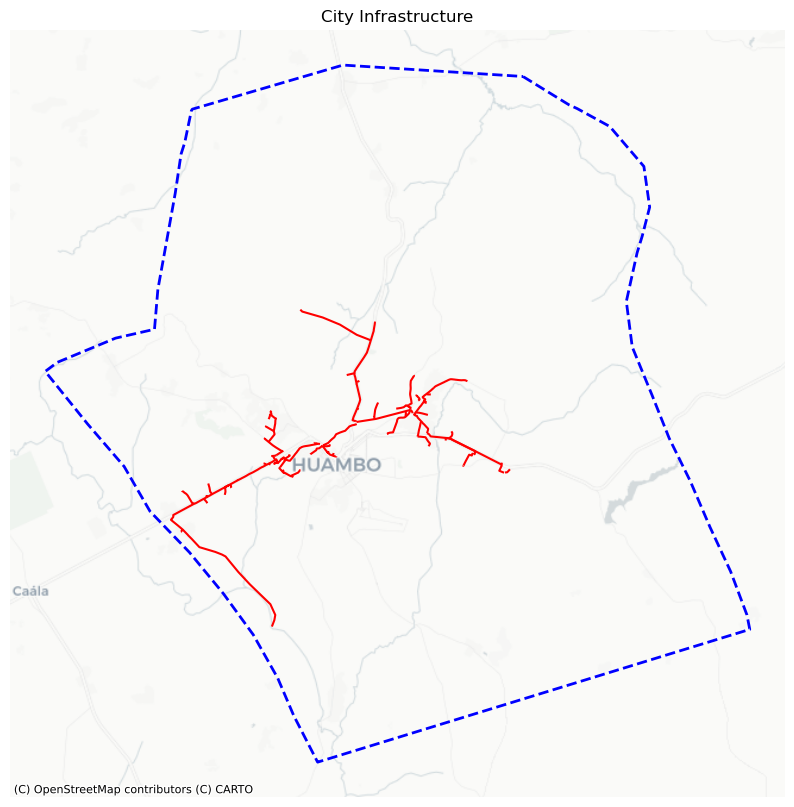

In [13]:
clipped_features_3857 = clipped_features.to_crs(epsg=3857)
city_path_3857 = city_path.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 10))
clipped_features_3857.plot(ax=ax, edgecolor='red', facecolor='none')
city_path_3857.plot(ax=ax, edgecolor='blue', facecolor='none', lw=2, linestyle='--')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_title('City Infrastructure')
plt.axis("off")
plt.show()

These are many subtypes to consider, so we combine some

Now define a new set of sub_types, to be used in the remainder of this analysis

In [14]:
sub_types = clipped_features.object_type.unique()

In [15]:
sub_types

array(['Cable'], dtype=object)

### Hazard Data
For this example, we make use of the flood data provided by [CDRI](https://giri.unepgrid.ch/map?list=explore).

We use a 1/100 flood map to showcase the approach.

In [87]:
hazard_map = xr.open_dataset("/Users/ipshitakarmakar/Dropbox (Personal)/WB/Angola/2024-04-energy-angola/02-process-output/huambo_pluvial_2020_1-10_clipped.tif", engine="rasterio")

In [88]:
hazard_map

<xarray.Dataset> Size: 8MB
Dimensions:      (band: 1, x: 1462, y: 1412)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 12kB 15.57 15.57 15.57 15.57 ... 15.97 15.97 15.97
  * y            (y) float64 11kB -12.55 -12.55 -12.55 ... -12.94 -12.94 -12.94
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 8MB ...

### Maximum damages
One of the most difficult parts of the assessment is to define the maximum reconstruction cost of particular assets. Here we provide a baseline set of values, but these should be updated through national consultations.

In [89]:
maxdam_dict = {'Cable':300} #how do we decide this?

To be used in our damage assessment, we convert this to a Pandas DataFrame

In [90]:
maxdam = pd.DataFrame.from_dict(maxdam_dict,orient='index').reset_index()
maxdam.columns = ['object_type','damage']

And check if any of the objects are missing from the dataframe.

In [91]:
missing = set(sub_types) - set(maxdam.object_type)

if len(missing) > 0:
    print(f"Missing object types in maxdam: \033[1m{', '.join(missing)}\033[0m. Please add them before you continue.")

### Vulnerability data
Similarly to the maximum damages, specifying the vulnerability curves is complex. We generally have limited information about the quality of the assets, its level of deteriation and other asset-level characteristics. The study by Nirandjan et al. (2024) provides us with a baseline set of fragility and vulnerability curves that one can use. In the following cell, we load that data.

In [92]:
vulnerability_path = "https://zenodo.org/records/10203846/files/Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V1.0.0.xlsx?download=1"
vul_df = pd.read_excel(vulnerability_path,sheet_name='F_Vuln_Depth')

And let's have a look at all the available options

In [93]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
  display(vul_df.iloc[:2,:].T)

,0,1
ID number,Infrastructure description,Additional characteristics
F1.1,plant,"Small power plants, capacity <100 MW"
F1.2,plant,"Medium power plants, capacity 100-500 MW"
F1.3,plant,"Large power plants, >500 MW"
F1.4,plant,thermal plant
F1.5,plant,wind turbine
F1.6,plant,wind turbine
F1.7,plant,wind turbine
F2.1,substation,Low Voltage Substation
F2.2,substation,Medium Voltage Substation


And select a curve to use for each different subtype we are analysing.

In [94]:
sub_types

array(['Cable'], dtype=object)

In [95]:
selected_curves = dict(zip(sub_types,['F2.1','F2.2']))

The next step is to extract the curves from the database, and prepare them for proper usage into our analysis.

We start by selecting the curve IDs from the larger pandas DataFrame **vul_df**:

In [96]:
damage_curves = vul_df[['ID number']+list(selected_curves.values())]
damage_curves = damage_curves.iloc[4:125,:]

Then for convenience, we rename the index name to the hazard intensity we are considering. 

In [ ]:
#i had to select a random curve here since they did not have one for lines

In [97]:
damage_curves.set_index('ID number',inplace=True)
damage_curves.index = damage_curves.index.rename('Depth')  

And make sure that our damage values are in floating numbers. 

In [98]:
damage_curves = damage_curves.astype(np.float32)

And ensure that the columns of the curves link back to the different asset types we are considering:

In [99]:
damage_curves.columns = sub_types

There could be some **NaN** values at the tail of some of the curves. To make sure the code works, we fill up the **NaN** values with the last value of each of the curves. 

In [100]:
damage_curves = damage_curves.fillna(method='ffill')

Finally, make sure we set the index of the damage curves (the inundation depth) in the same metric as the hazard data (e.g. meters or centimeters).

In [101]:
damage_curves.index = damage_curves.index*100

### Ancilliary data for processing

In [102]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
world_plot = world.to_crs(3857)

In [103]:
admin1 = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_1_states_provinces.shp")

## 3. Preparing the Data

Change the column name of the object data, to ensure we can use the same functions across different infrastructure assets

In [104]:
clipped_features = features.rename(columns = {'Cable' : 'object_type'})

Clip the hazard data to the country of interest.

In [105]:
country_bounds = world.loc[world.ADM0_ISO == country_iso3].bounds
country_geom = world.loc[world.ADM0_ISO == country_iso3].geometry

In [106]:
country_gdf = gpd.GeoDataFrame(geometry=country_geom, crs="EPSG:4326")
clipped_country = gpd.clip(country_gdf, city_path)

In [107]:
hazard_country = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                     miny=country_bounds.miny.values[0],
                     maxx=country_bounds.maxx.values[0],
                     maxy=country_bounds.maxy.values[0]
                    )

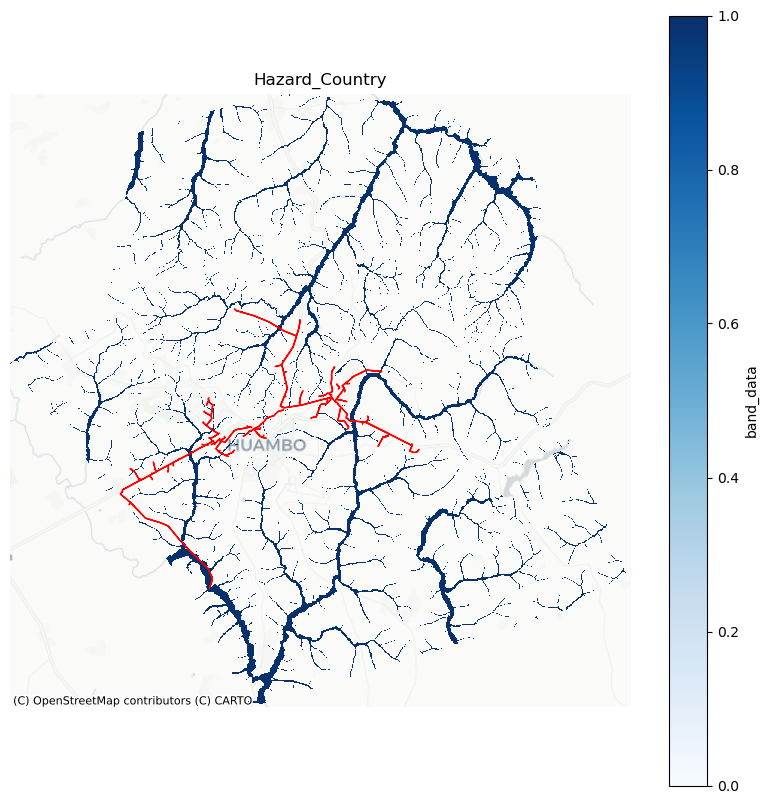

In [126]:
hazard_3857 = hazard_country.band_data.rio.reproject("EPSG:3857")
features_3857 = features.to_crs(epsg=3857)
country_3857 = country_gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 10))
hazard_3857.plot(ax=ax, cmap="Blues", vmin=0)
features_3857.plot(ax=ax, edgecolor='red', facecolor='none')
country_3857.plot(ax=ax, edgecolor='blue', facecolor='none', lw=2, linestyle='--')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.title("Hazard_Country")
plt.axis("off")
plt.show()

In [109]:

hazard_city = hazard_country.rio.clip(city_path.geometry, city_path.crs)

In [110]:
clipped_features = clipped_features.to_crs("EPSG:3857")

# 2. Buffer in meters (e.g., 10 meters)
clipped_features["geometry"] = clipped_features.geometry.buffer(1)

# 3. Project back to original CRS (e.g., EPSG:4326)
features = clipped_features.to_crs("EPSG:4326")

/var/folders/tb/lt6mv9zn47973s97jtlwv_b40000gn/T/ipykernel_75926/1029918928.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower right', fontsize='small', frameon=True)
/var/folders/tb/lt6mv9zn47973s97jtlwv_b40000gn/T/ipykernel_75926/1029918928.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right', fontsize='small', frameon=True)


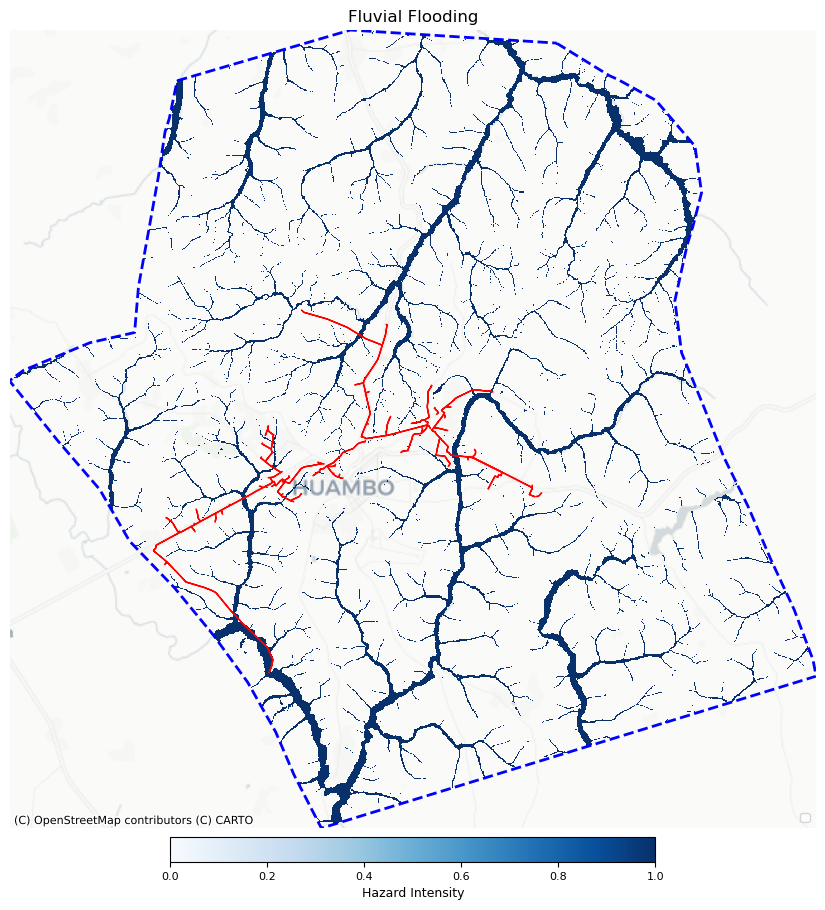

In [111]:
hazard_3857 = hazard_city.band_data.rio.reproject("EPSG:3857")

# Reproject vector layers
city_path_3857 = city_path.to_crs(epsg=3857)
features_3857 = features.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot raster
hazard_plot = hazard_3857.plot(ax=ax, cmap="Blues", vmin=0, add_colorbar=False)

# Plot vector layers
city_path_3857.plot(ax=ax, edgecolor='blue', facecolor='none', lw=2, linestyle='--', label='City Path')
features_3857.plot(ax=ax, edgecolor='red', facecolor='none', label='Features')

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Add colorbar
cbar = fig.colorbar(hazard_plot, ax=ax, shrink=0.5, orientation='horizontal', pad=0.01, aspect=20)
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Hazard Intensity", fontsize=9)

# Add legend
ax.legend(loc='lower right', fontsize='small', frameon=True)

# Final formatting
plt.title("Fluvial Flooding")
plt.axis("off")
plt.tight_layout()
plt.show()

In [112]:

warnings.filterwarnings("ignore", category=UserWarning, message="Geometry is in a geographic CRS")

def prepare_features(features_gdf, hazard_crs=None):
    """
    Cleans and prepares a GeoDataFrame for overlay operations with a raster.
    
    - Fixes invalid geometries.
    - Drops null or empty geometries.
    - Aligns CRS with raster CRS.
    """
    
    # Step 1: Drop rows with missing or empty geometries
    features_gdf = features_gdf[features_gdf.geometry.notnull()]
    features_gdf = features_gdf[~features_gdf.geometry.is_empty]

    # Step 2: Check for invalid geometries
    invalid = features_gdf[~features_gdf.is_valid]
    print(f"Found {len(invalid)} invalid geometries.")

    if len(invalid) > 0:
        print("Attempting to fix invalid geometries with buffer(0)...")
        features_gdf['geometry'] = features_gdf['geometry'].buffer(0)

    # Step 3: Drop any geometries that are still invalid or become empty
    features_gdf = features_gdf[features_gdf.is_valid]
    features_gdf = features_gdf[~features_gdf.geometry.is_empty]

    # Step 4: Keep only polygon-type geometries (optional, depending on use case)
    features_gdf = features_gdf[features_gdf.geometry.type.isin(['Polygon', 'MultiPolygon'])]

    # Step 5: Reproject to raster CRS if needed
    if hazard_crs and features_gdf.crs != hazard_crs:
        print("Reprojecting vector data to match raster CRS...")
        features_gdf = features_gdf.to_crs(hazard_crs)

    print(f"Prepared {len(features_gdf)} geometries.")
    return features_gdf


In [113]:
import rioxarray
hazard_map.rio.write_crs("EPSG:4326", inplace=True)  # only if CRS is missing; replace with actual EPSG if known
hazard_crs = hazard_map.rio.crs
features_cleaned = prepare_features(features, hazard_crs=hazard_crs)

Found 0 invalid geometries.
Prepared 61 geometries.


In [114]:
exposure_results = DamageScanner(hazard_city, features, damage_curves, maxdam).exposure()

convert coverage to meters: 100%|████████████| 14/14 [00:00<00:00, 26121.11it/s]


## 4. Performing an Exposure Assessment
We will use the DamageScanner approach. This is a fully optimised damage calculation method, that can capture a wide range of inputs to perform a damage assessment. It also allows to only assess the potential exposure.

## 5. Performing a Vulnerability Assessment
In some cases, the cost information is unavailable, or one wants to explore only the exposure and vulnerability. To do so, we simply run the DamageScanner, by setting the maximum costs to 1.

In [115]:
vulnerability_maxdam = maxdam.copy()
vulnerability_maxdam.loc[:,'damage'] = maxdam['damage']/maxdam['damage']

In [116]:
%%time
features["object_type"] = "Cable"
vulnerability_results = DamageScanner(hazard_country, features, damage_curves, vulnerability_maxdam).calculate()

Calculating damage: 100%|████████████████████| 14/14 [00:00<00:00, 20919.22it/s]

CPU times: user 165 ms, sys: 4.73 ms, total: 169 ms
Wall time: 172 ms


In [117]:
vulnerability_results = DamageScanner(hazard_city, features, damage_curves, vulnerability_maxdam).calculate()

Calculating damage: 100%|████████████████████| 14/14 [00:00<00:00, 24006.65it/s]


## 6. Performing the Damage Assessment
In case we do have cost values, we can fully assess the damages.

In [118]:
%%time
country_damage_results = DamageScanner(hazard_country, features, damage_curves, maxdam).calculate()

Calculating damage: 100%|████████████████████| 14/14 [00:00<00:00, 24045.97it/s]

CPU times: user 166 ms, sys: 6.55 ms, total: 172 ms
Wall time: 172 ms


In [119]:
%%time
damage_results = DamageScanner(hazard_city, features, damage_curves, maxdam).calculate()

Calculating damage: 100%|████████████████████| 14/14 [00:00<00:00, 24786.94it/s]

CPU times: user 163 ms, sys: 4.8 ms, total: 168 ms
Wall time: 170 ms


## 7. Save the Results
For further analysis, we can save the results in their full detail, or save summary estimates per subnational unit. We show how to do this using the damage results.

In [33]:
# hazard = 'river_flood'
# return_period = '1_100'
# damage_results.to_file(f'Road_Damage_{country_full_name}_{hazard}_{return_period}.gpkg')

In [34]:
# admin1_country = admin1.loc[admin1.sov_a3 == country_iso3]

In [35]:
# damage_results = damage_results.sjoin(admin1_country[['adm1_code','name','geometry']])

In [36]:
# admin1_damage = admin1_country.merge(damage_results[['name_right','damage']].groupby('name_right').sum(),
                                     left_on='name',
                                     right_on='name_right',
                                     how='outer')[['name','adm1_code','geometry','damage']]

In [37]:
# admin1_damage.to_file(f'Admin1_Road_Damage_{country_full_name}_{hazard}_{return_period}.gpkg')

## 8. Visualizing the Results
The results of the damage assessment can be visualized using charts and maps. This will provide a clear representation of which infrastructure is most affected by the hazard and the expected damage levels.

Find the locations of the twenty most damaged roads.

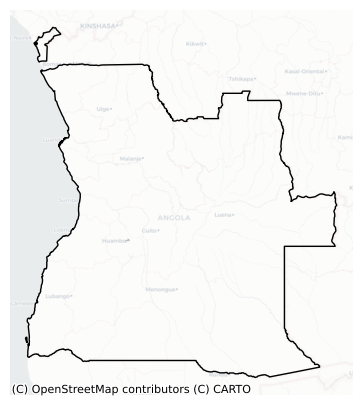

In [121]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))

country_damage_results.to_crs(3857).sort_values('damage',ascending=False).head(20).plot(ax=ax,color='Red')
features.to_crs(3857).plot(ax=ax,facecolor="none",edgecolor='grey',alpha=0.5,zorder=2,lw=0.1)
world_plot.loc[world.SOV_A3 == country_iso3].plot(ax=ax,facecolor="none",edgecolor='black')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

And create a distribution of the damages.

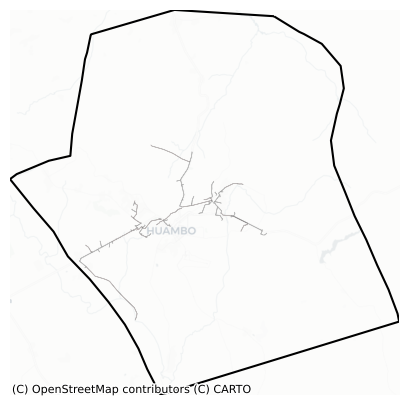

In [122]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
damage_results.to_crs(3857).plot(ax=ax, color='Red',lw=3)
features.to_crs(3857).plot(ax=ax, facecolor="none", edgecolor='grey', alpha=0.5, zorder=2, lw=0.5)
city_path.to_crs(3857).plot(ax=ax, facecolor="none", edgecolor='black', linewidth=1.5)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, alpha=0.5)
ax.set_axis_off()
minx, miny, maxx, maxy = city_path.to_crs(3857).total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()


<Axes: xlabel='damage', ylabel='Count'>

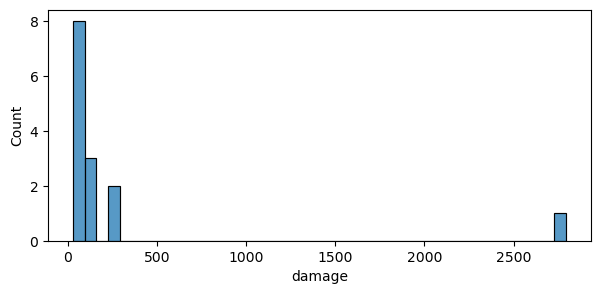

In [123]:
fig, ax = plt.subplots(1,1,figsize=(7, 3))

sns.histplot(data=damage_results,x='damage',ax=ax)

Plot all damages

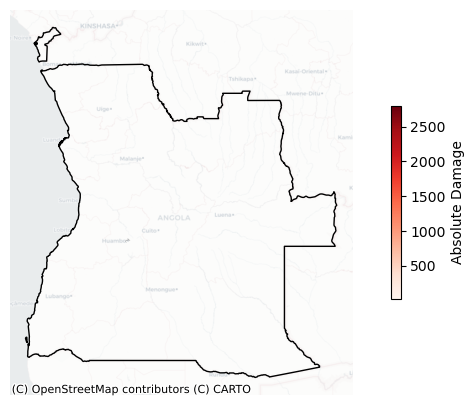

In [124]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))

damage_results.to_crs(3857).plot(ax=ax,column='damage',cmap='Reds',legend=True,
                   legend_kwds={'shrink': 0.5,'label':'Absolute Damage'},zorder=5)
features.to_crs(3857).plot(ax=ax,facecolor="none",edgecolor='grey',alpha=0.5,zorder=2,lw=0.1)
world_plot.loc[world.SOV_A3 == country_iso3].plot(ax=ax,facecolor="none",edgecolor='black')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

In [125]:
viz(damage_results)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

## 9. Performing the Risk Assessment
To do so, we need to select the return periods we want to include, and create a dictioniary as input. We will create this below.

In [161]:
# return_periods = [2,5,10,50,100,200,500,1000]

# hazard_dict = {}
# for return_period in return_periods:
#     hazard_map = xr.open_dataset(f"https://hazards-data.unepgrid.ch/global_pc_h{return_period}glob.tif", engine="rasterio")

#     hazard_dict[return_period] = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
#                      miny=country_bounds.miny.values[0],
#                      maxx=country_bounds.maxx.values[0],
#                      maxy=country_bounds.maxy.values[0]
#                     )
    

In [163]:
# risk_results = DamageScanner(hazard_country, features, damage_curves, maxdam).risk(hazard_dict)

## 10. Visualize the Risk Assessment
To understand the relative shares of each component of the system, we create a pie chart with the percentages of risk to each component.

In [53]:
# risk_per_object = risk_results[['object_type','risk']].groupby('object_type').sum()

Here we set the colors.

In [54]:
# colors = ['#8c510a','#d8b365','#f6e8c3','#c7eae5','#5ab4ac','#01665e'][::-1] 

And create the figure

Text(0.5, 1.0, 'River Flood Risk for Tajikistan')

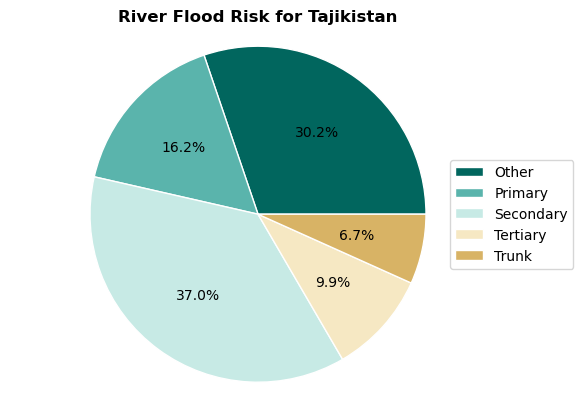

In [55]:
# # labels = [x.capitalize() for x in list(risk_per_object.index)]
# sizes = risk_per_object.risk.values
# pie = plt.pie(sizes,autopct='%1.1f%%', labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);
# plt.axis('equal')
# plt.legend(loc = 'right', labels=labels,bbox_to_anchor=(1.15, 0.5),)
# plt.title(f'River Flood Risk for {country_full_name}',fontweight='bold')